In [1]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 9.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstalling sentence-transformers-3.3.1:
      Successfully uninstalled sentence-transformers-3.3.1


# 6/4/25

In [2]:
!pip install fastcluster

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 6.8 MB/s eta 0:00:00


# 7/4

In [4]:
import json
import numpy as np
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from cuml.manifold import UMAP as cumlUMAP
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from collections import defaultdict
import pandas as pd
import torch
import gc
import os
from itertools import product

# === Config ===
INPUT_JSON = "/kaggle/input/keywords-timeline/keyword_timeline.json"
OUTPUT_DIR = "./timeline_cluster_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# UMAP and clustering params
N_COMPONENTS = [10]
N_NEIGHBORS = [5, 10, 20]
MIN_DISTS = [0.01, 0.05, 0.1, 0.25, 0.5]
DIST_THRESHOLDS = [0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4]

# === Load model ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# === Load keyword-year mapping ===
with open(INPUT_JSON, 'r', encoding='utf-8') as f:
    keyword_to_years = json.load(f)

keywords = list(keyword_to_years.keys())
print(f"Loaded {len(keywords)} unique keywords")

# === Embed keywords ===
print("Encoding keywords...")
dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
all_embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=False)
    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings).astype(np.float32)

# === Run for each UMAP + clustering config ===
results = []

for n_comp, n_neigh, min_dist, dist_thresh in product(N_COMPONENTS, N_NEIGHBORS, MIN_DISTS, DIST_THRESHOLDS):
    print(f"\n🔧 UMAP(n_components={n_comp}, n_neighbors={n_neigh}, min_dist={min_dist}) + Fastcluster(thresh={dist_thresh})")

    # Apply UMAP
    umap_model = cumlUMAP(
        n_components=n_comp,
        n_neighbors=n_neigh,
        min_dist=min_dist,
        metric='cosine',
        random_state=42
    )
    reduced = umap_model.fit_transform(embeddings)
    if hasattr(reduced, 'get'):
        reduced = reduced.get()

    # Fastcluster
    linkage_matrix = fastcluster.linkage_vector(reduced, method='ward')
    labels = fcluster(linkage_matrix, t=dist_thresh, criterion='distance')
    n_clusters = len(set(labels))

    # Silhouette score (only if >1 cluster)
    silhouette = silhouette_score(reduced, labels) if n_clusters > 1 else -1

    # Create cluster structure
    clusters = defaultdict(lambda: {"keywords": [], "years": set()})
    for kw, label in zip(keywords, labels):
        clusters[f"cluster_{label}"]["keywords"].append(kw)
        clusters[f"cluster_{label}"]["years"].update(keyword_to_years[kw])
    for cluster in clusters.values():
        cluster["years"] = sorted(cluster["years"])

    # Save cluster JSON
    filename_json = f"clusters_nc{n_comp}_nn{n_neigh}_md{min_dist}_dt{dist_thresh}.json"
    with open(os.path.join(OUTPUT_DIR, filename_json), "w", encoding="utf-8") as f:
        json.dump(clusters, f, indent=2, ensure_ascii=False)

    # Log results
    results.append({
        "n_components": n_comp,
        "n_neighbors": n_neigh,
        "min_dist": min_dist,
        "distance_threshold": dist_thresh,
        "n_clusters": n_clusters,
        "silhouette_score": silhouette,
        "output_file": filename_json
    })

    # Free GPU memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        try:
            import cupy as cp
            cp._default_memory_pool.free_all_blocks()
        except:
            pass

# Save results summary
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)
print("\n✅ All done! Cluster JSONs + summary saved in:", OUTPUT_DIR)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded 11665 unique keywords
Encoding keywords...

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=0.1)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=0.25)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=0.5)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=1)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=1.5)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=2)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=3)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.01) + Fastcluster(thresh=4)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.05) + Fastcluster(thresh=0.1)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.05) + Fastcluster(thresh=0.25)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.05) + Fastcluster(thresh=0.5)

🔧 UMAP(n_components=10, n_neighbors=5, min_dist=0.05) + Fastclus

In [6]:
import json
import numpy as np
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from collections import defaultdict
import pandas as pd
import torch
import os

# === Config ===
INPUT_JSON = "/kaggle/input/keywords-timeline/keyword_timeline.json"
OUTPUT_DIR = "./timeline_cluster_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DIST_THRESHOLDS = [0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4]

# === Load model ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# === Load keyword-year mapping ===
with open(INPUT_JSON, 'r', encoding='utf-8') as f:
    keyword_to_years = json.load(f)

keywords = list(keyword_to_years.keys())
print(f"Loaded {len(keywords)} unique keywords")

# === Embed keywords ===
print("Encoding keywords...")
dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
all_embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=False)
    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings).astype(np.float32)

# === Run for each UMAP + clustering config ===
results = []

for dist_thresh in DIST_THRESHOLDS:
    print(f"\n🔧 Fastcluster(thresh={dist_thresh})")

    # Fastcluster
    linkage_matrix = fastcluster.linkage_vector(embeddings, method='ward')
    labels = fcluster(linkage_matrix, t=dist_thresh, criterion='distance')
    n_clusters = len(set(labels))

    # Silhouette score (only if >1 cluster)
    silhouette = silhouette_score(embeddings, labels) if n_clusters > 1 else -1

    # Create cluster structure
    clusters = defaultdict(lambda: {"keywords": [], "years": set()})
    for kw, label in zip(keywords, labels):
        clusters[f"cluster_{label}"]["keywords"].append(kw)
        clusters[f"cluster_{label}"]["years"].update(keyword_to_years[kw])
    for cluster in clusters.values():
        cluster["years"] = sorted(cluster["years"])

    # Save cluster JSON
    filename_json = f"clusters_dt{dist_thresh}.json"
    with open(os.path.join(OUTPUT_DIR, filename_json), "w", encoding="utf-8") as f:
        json.dump(clusters, f, indent=2, ensure_ascii=False)

    # Log results
    results.append({
        "distance_threshold": dist_thresh,
        "n_clusters": n_clusters,
        "silhouette_score": silhouette,
        "output_file": filename_json
    })


# Save results summary
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)
print("\n✅ All done! Cluster JSONs + summary saved in:", OUTPUT_DIR)


Loaded 11665 unique keywords
Encoding keywords...

🔧 Fastcluster(thresh=0.1)

🔧 Fastcluster(thresh=0.25)

🔧 Fastcluster(thresh=0.5)

🔧 Fastcluster(thresh=1)

🔧 Fastcluster(thresh=1.5)

🔧 Fastcluster(thresh=2)

🔧 Fastcluster(thresh=3)

🔧 Fastcluster(thresh=4)

✅ All done! Cluster JSONs + summary saved in: ./timeline_cluster_results


In [7]:
!zip -r output_files.zip /kaggle/working/timeline_cluster_results

  adding: kaggle/working/timeline_cluster_results/ (stored 0%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt1.5.json (deflated 86%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt0.5.json (deflated 87%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt0.1.json (deflated 87%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt3.json (deflated 83%)
  adding: kaggle/working/timeline_cluster_results/summary_results.csv (deflated 50%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt0.25.json (deflated 87%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt1.json (deflated 86%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt2.json (deflated 85%)
  adding: kaggle/working/timeline_cluster_results/clusters_dt4.json (deflated 82%)


In [3]:
import json
import numpy as np
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from collections import defaultdict
import pandas as pd
import torch
import os

# === Config ===
INPUT_JSON = "/kaggle/input/keywords-timeline/keyword_timeline.json"
OUTPUT_DIR = "./timeline_cluster_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DIST_THRESHOLDS = [1, 1.5]

# === Load model ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# === Load keyword -> [years] mapping ===
with open(INPUT_JSON, 'r', encoding='utf-8') as f:
    keyword_to_years = json.load(f)

keywords = list(keyword_to_years.keys())
print(f"Loaded {len(keywords)} unified keywords")

# === Embed keywords ===
print("Encoding keywords...")
dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
all_embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=False)
    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings).astype(np.float32)

all_summary=[]
for dist in DIST_THRESHOLDS:
    # === Fastcluster clustering ===
    print(f"\n🔧 Fastcluster(thresh={dist})")
    linkage_matrix = fastcluster.linkage_vector(embeddings, method='ward')
    labels = fcluster(linkage_matrix, t=dist, criterion='distance')
    n_clusters = len(set(labels))
    
    # Silhouette score
    silhouette = silhouette_score(embeddings, labels) if n_clusters > 1 else -1
    
    # === Create cluster structure with aggregated year counts ===
    clustered_keywords = defaultdict(list)
    for kw, label in zip(keywords, labels):
        clustered_keywords[f"cluster_{label}"].append(kw)
    
    # Final output: cluster_label -> {"keywords": [...], "years": {year: count, ...}}
    clusters = {}
    for cluster_id, kws in clustered_keywords.items():
        year_counts = defaultdict(int)
        for kw in kws:
            for year, count in keyword_to_years[kw].items():
                year_counts[year] += count
    
        clusters[cluster_id] = {
            "keywords": kws,
            "years": dict(sorted(year_counts.items()))
        }
    
    # Save cluster JSON
    filename_json = f"clusters_dt{dist}_with_year_counts.json"
    with open(os.path.join(OUTPUT_DIR, filename_json), "w", encoding="utf-8") as f:
        json.dump(clusters, f, indent=2, ensure_ascii=False)
    
    # Log results
    summary = [{
        "distance_threshold": dist,
        "n_clusters": n_clusters,
        "silhouette_score": silhouette,
        "output_file": filename_json
    }]
    all_summary.append(summary)
    
df = pd.DataFrame(all_summary)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)

print("\n✅ Done! Cluster JSON with year counts saved in:", OUTPUT_DIR)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded 11666 unified keywords
Encoding keywords...

🔧 Fastcluster(thresh=1)

🔧 Fastcluster(thresh=1.5)

✅ Done! Cluster JSON with year counts saved in: ./timeline_cluster_results


In [5]:
# Final output: cluster_label -> {"keywords": [...], "years": {year: count, ...}}
clusters = {}
for cluster_id, kws in clustered_keywords.items():
    year_counts = defaultdict(int)
    for kw in kws:
        for year, count in keyword_to_years[kw].items():
            year_counts[year] += count

    clusters[cluster_id] = {
        "keywords": kws,
        "years": dict(sorted(year_counts.items()))
    }

# Save cluster JSON
filename_json = f"clusters_dt{DIST_THRESHOLDS}_with_year_counts.json"
with open(os.path.join(OUTPUT_DIR, filename_json), "w", encoding="utf-8") as f:
    json.dump(clusters, f, indent=2, ensure_ascii=False)

# Log results
summary = [{
    "distance_threshold": DIST_THRESHOLDS,
    "n_clusters": n_clusters,
    "silhouette_score": silhouette,
    "output_file": filename_json
}]
df = pd.DataFrame(summary)
df.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)

print("\n✅ Done! Cluster JSON with year counts saved in:", os.path.join(OUTPUT_DIR, filename_json))


✅ Done! Cluster JSON with year counts saved in: ./timeline_cluster_results/clusters_dt0.5_with_year_counts.json


# END

In [3]:
import os
import json
import numpy as np
import torch
import gc
from itertools import product
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP as cumlUMAP
from sklearn.metrics import silhouette_score
import fastcluster
from scipy.cluster.hierarchy import fcluster
import pandas as pd
from torch.utils.data import DataLoader

# Constants
INPUT_DIR = "/kaggle/input/ugp-data/UGP (new)"
OUTPUT_DIR = "./clustering_results_new"
os.makedirs(OUTPUT_DIR, exist_ok=True)

YEARS = [2011]
N_COMPONENTS = [10, 20, 30]
N_NEIGHBORS = [10, 20]
MIN_DISTS = [0.01, 0.05, 0.1]
DIST_THRESHOLDS = [1, 2, 3]

# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Store scores
results = []

def load_keywords(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return list(set(kw for entry in data for kw in entry.get("keywords", [])))

for year in YEARS:
    file_path = os.path.join(INPUT_DIR, f"{year}.json")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    print(f"\n[ {year} ] Loading keywords...")
    keywords = load_keywords(file_path)
    if not keywords:
        print("No keywords found.")
        continue

    print(f"Encoding {len(keywords)} keywords...")
    dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
    all_embeddings = []
    for batch in dataloader:
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        all_embeddings.append(batch_embeddings)

    embeddings = np.vstack(all_embeddings).astype(np.float32)

    for n_comp, n_neigh, min_dist in product(N_COMPONENTS, N_NEIGHBORS, MIN_DISTS):
        print(f"→ UMAP(n_components={n_comp}, n_neighbors={n_neigh}, min_dist={min_dist})")

        # Apply cuML UMAP
        umap_model = cumlUMAP(n_components=n_comp, n_neighbors=n_neigh, min_dist=min_dist, metric='cosine', random_state=42)
        reduced = umap_model.fit_transform(embeddings)
        if hasattr(reduced, 'get'):
            reduced = reduced.get()

        for dist_thresh in DIST_THRESHOLDS:
            # Fastcluster (scipy-style)
            linkage_matrix = fastcluster.linkage_vector(reduced, method='ward')
            labels_fast = fcluster(linkage_matrix, t=dist_thresh, criterion='distance')

            if len(set(labels_fast)) > 1:
                sil_fast = silhouette_score(reduced, labels_fast)
            else:
                sil_fast = -1

            clusters_fast = {}
            for kw, label in zip(keywords, labels_fast):
                clusters_fast.setdefault(str(label), []).append(kw)
            filename = f"{year}_fastclust_nc{n_comp}_nn{n_neigh}_md{min_dist}_dt{dist_thresh}.json"
            with open(os.path.join(OUTPUT_DIR, filename), "w", encoding="utf-8") as f:
                json.dump(clusters_fast, f, indent=2, ensure_ascii=False)

            results.append({
                "year": year,
                "method": "Fastcluster",
                "n_components": n_comp,
                "n_neighbors": n_neigh,
                "min_dist": min_dist,
                "distance_threshold": dist_thresh,
                "silhouette": sil_fast
            })

            # Free GPU memory
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                try:
                    import cupy as cp
                    cp._default_memory_pool.free_all_blocks()
                except:
                    pass

# Save silhouette scores
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUTPUT_DIR, "silhouette_scores_fastcluster.csv"), index=False)
print("✅ All done! Scores saved to silhouette_scores_fastcluster.csv")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


[ 2011 ] Loading keywords...
Encoding 30173 keywords...
→ UMAP(n_components=10, n_neighbors=10, min_dist=0.01)
→ UMAP(n_components=10, n_neighbors=10, min_dist=0.05)
→ UMAP(n_components=10, n_neighbors=10, min_dist=0.1)
→ UMAP(n_components=10, n_neighbors=20, min_dist=0.01)
→ UMAP(n_components=10, n_neighbors=20, min_dist=0.05)
→ UMAP(n_components=10, n_neighbors=20, min_dist=0.1)
→ UMAP(n_components=20, n_neighbors=10, min_dist=0.01)
→ UMAP(n_components=20, n_neighbors=10, min_dist=0.05)
→ UMAP(n_components=20, n_neighbors=10, min_dist=0.1)
→ UMAP(n_components=20, n_neighbors=20, min_dist=0.01)
→ UMAP(n_components=20, n_neighbors=20, min_dist=0.05)
→ UMAP(n_components=20, n_neighbors=20, min_dist=0.1)
→ UMAP(n_components=30, n_neighbors=10, min_dist=0.01)
→ UMAP(n_components=30, n_neighbors=10, min_dist=0.05)
→ UMAP(n_components=30, n_neighbors=10, min_dist=0.1)
→ UMAP(n_components=30, n_neighbors=20, min_dist=0.01)
→ UMAP(n_components=30, n_neighbors=20, min_dist=0.05)
→ UMAP(n_comp

In [4]:
!zip -r output_files.zip /kaggle/working/clustering_results_new

  adding: kaggle/working/clustering_results_new/ (stored 0%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc20_nn20_md0.01_dt2.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc10_nn10_md0.01_dt1.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc10_nn10_md0.05_dt1.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc30_nn20_md0.01_dt1.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc30_nn20_md0.05_dt3.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc30_nn10_md0.1_dt1.json (deflated 76%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc30_nn10_md0.1_dt3.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc10_nn10_md0.1_dt3.json (deflated 77%)
  adding: kaggle/working/clustering_results_new/2011_fastclust_nc30_nn20_md0.1_dt3.json (deflated 77%)
  addin

In [2]:
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')

# The sentences to encode
sentences = [
        "Dielectric Barrier Discharge Reactors",
        "Redox-active Azo Groups",
        "Micro-photoluminescence Spectroscopy",
        "Tunable Plasmon Resonance",
        "quantum transport measurements",
        "Sulfur vacancy passivation",
        "Nanoscale damage mechanics",
        "Dzyaloshinskii Moriya interaction",
        "Solution-Processed Indium Oxide",
        "Stretchable Haptic Research",
        "Reverse Micelle Method",
        "soft conductive materials",
        "Conductive foam materials",
    ]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
similarities

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(13, 384)


tensor([[ 1.0000, -0.0570,  0.0551,  0.0191,  0.1117,  0.1803,  0.1161,  0.0345,
          0.2727,  0.0777, -0.0174,  0.1992,  0.2240],
        [-0.0570,  1.0000,  0.2048,  0.0701,  0.0549,  0.2066,  0.0758,  0.2036,
          0.1716,  0.0541,  0.0588,  0.0638,  0.0262],
        [ 0.0551,  0.2048,  1.0000,  0.2163,  0.2357,  0.1615,  0.1736,  0.1490,
          0.0966,  0.0591,  0.0170,  0.0985,  0.0664],
        [ 0.0191,  0.0701,  0.2163,  1.0000,  0.1222,  0.2031,  0.1725,  0.0277,
          0.1207,  0.1934,  0.0817,  0.2214,  0.1716],
        [ 0.1117,  0.0549,  0.2357,  0.1222,  1.0000,  0.2167,  0.0877,  0.1009,
         -0.0366,  0.0924,  0.0017,  0.0814,  0.0356],
        [ 0.1803,  0.2066,  0.1615,  0.2031,  0.2167,  1.0000,  0.0978,  0.0758,
          0.1892,  0.0365, -0.0551,  0.0502,  0.0320],
        [ 0.1161,  0.0758,  0.1736,  0.1725,  0.0877,  0.0978,  1.0000,  0.0287,
          0.0778,  0.2371,  0.1526,  0.2123,  0.1624],
        [ 0.0345,  0.2036,  0.1490,  0.0277,  0.

<Axes: >

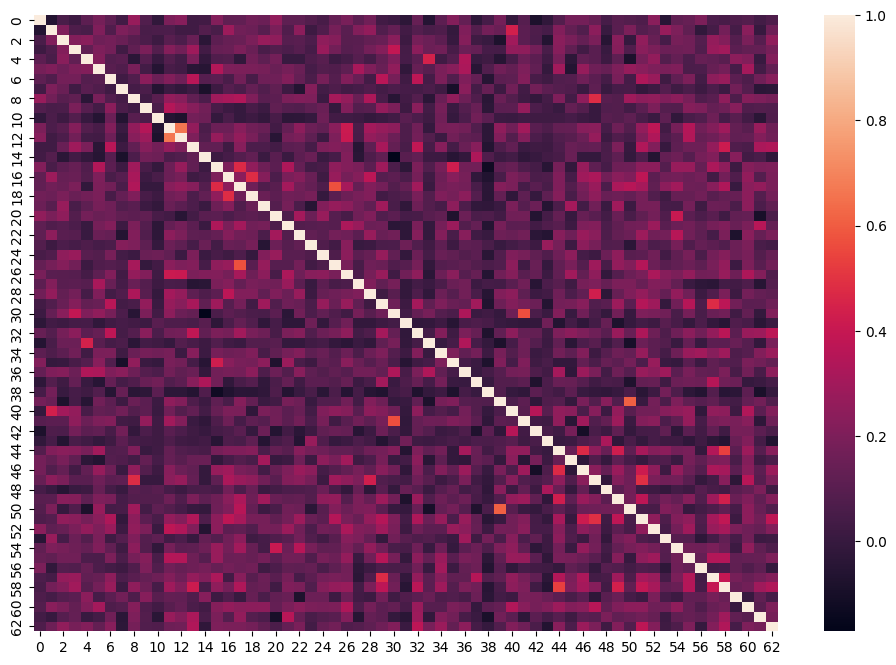

In [37]:
similarities = model.similarity(embeddings, embeddings)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

sns.heatmap(similarities)

In [34]:
import plotly.express as px

# Create an interactive heatmap
fig = px.imshow(
    similarities,
    labels=dict(x="Index", y="Index", color="Similarity"),
    color_continuous_scale="viridis"
)

# Update layout for better interactivity
fig.update_layout(
    title="Zoomable Similarity Heatmap",
    xaxis=dict(side="top", tickangle=-45),
    yaxis=dict(autorange="reversed"),
    dragmode="pan",  # Enables zooming and panning
)

# Show the plot
fig.show()


In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00


In [5]:
import os
import json
import numpy as np
import torch
import gc
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from cuml.manifold import UMAP  # GPU-accelerated UMAP from RAPIDS cuML

# Directory containing year-wise JSON files (2011.json to 2024.json)
INPUT_DIR = "/kaggle/input/ugp-data/UGP (new)"
OUTPUT_DIR = "./umap_embeddings"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Sentence-BERT model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Load keywords from JSON
def load_keywords(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return list(set(kw for entry in data for kw in entry.get("keywords", [])))

# Process year-wise files
for year in range(2011, 2025):
    file_path = os.path.join(INPUT_DIR, f"{year}.json")
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    print(f"\n[ {year} ] Loading keywords...")
    keywords = load_keywords(file_path)
    if not keywords:
        print("No keywords found.")
        continue

    print(f"Encoding {len(keywords)} keywords with SBERT...")
    dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
    all_embeddings = []

    for batch in dataloader:
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        all_embeddings.append(batch_embeddings)

    embeddings = np.vstack(all_embeddings).astype(np.float32)

    print("Applying cuML UMAP...")
    umap_model = UMAP(
        n_components=40,
        n_neighbors=10,
        min_dist=0.01,
        metric='cosine',
        random_state=42
    )
    umap_embeddings = umap_model.fit_transform(embeddings)

    # Convert to NumPy (cuDF/cupy to NumPy)
    if hasattr(umap_embeddings, 'get'):
        umap_embeddings = umap_embeddings.get()
    elif hasattr(umap_embeddings, 'to_numpy'):
        umap_embeddings = umap_embeddings.to_numpy()

    output_path = os.path.join(OUTPUT_DIR, f"{year}_umap.npy")
    np.save(output_path, umap_embeddings)
    print(f"Saved embeddings: {output_path}")

    # Clear memory (important on GPU)
    del embeddings, umap_model, umap_embeddings, all_embeddings, dataloader
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using device: cuda

[ 2011 ] Loading keywords...
Encoding 30173 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2011_umap.npy

[ 2012 ] Loading keywords...
Encoding 30084 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2012_umap.npy

[ 2013 ] Loading keywords...
Encoding 39489 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2013_umap.npy

[ 2014 ] Loading keywords...
Encoding 40820 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2014_umap.npy

[ 2015 ] Loading keywords...
Encoding 40915 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2015_umap.npy

[ 2016 ] Loading keywords...
Encoding 37426 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2016_umap.npy

[ 2017 ] Loading keywords...
Encoding 38293 keywords with SBERT...
Applying cuML UMAP...
Saved embeddings: ./umap_embeddings/2017_umap.npy



In [6]:
!zip -r output_files.zip /kaggle/working/umap_embeddings

  adding: kaggle/working/umap_embeddings/ (stored 0%)
  adding: kaggle/working/umap_embeddings/2011_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2017_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2013_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2016_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2015_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2020_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2021_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2022_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2023_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2024_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2012_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2019_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2018_umap.npy (deflated 9%)
  adding: kaggle/working/umap_embeddings/2014_uma

In [38]:
import umap
umap_reducer = umap.UMAP(n_components=40, n_neighbors=10, min_dist=0.01, metric='cosine', random_state=42)
final_embeddings_umap = umap_reducer.fit_transform(embeddings)

similarities = model.similarity(final_embeddings_umap, final_embeddings_umap)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [39]:
print(final_embeddings_umap.shape)
# Create an interactive heatmap
fig = px.imshow(
    similarities,
    labels=dict(x="Index", y="Index", color="Similarity"),
    color_continuous_scale="viridis"
)

# Update layout for better interactivity
fig.update_layout(
    title="Zoomable Similarity Heatmap",
    xaxis=dict(side="top", tickangle=-45),
    yaxis=dict(autorange="reversed"),
    dragmode="pan",  # Enables zooming and panning
)

# Show the plot
fig.show()


(63, 40)


In [ ]:
##### import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader

# Load JSON and extract keywords for a given year
def load_keywords_from_json(file_path, target_year):
    with open(file_path, 'r') as f:
        data = json.load(f)
    keywords = []
    for entry in data:
        if entry['year'] == target_year:
            keywords.extend(entry['keywords'])
    return list(set(keywords)) 

# Load Sentence-BERT model with GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

keywords_2011 = load_keywords_from_json('/kaggle/input/2011-2018-mrs-dataset/2011-2018-fall.json', target_year=2011)
dataloader = DataLoader(keywords_2011, batch_size=1024, shuffle=False)
embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.append(batch_embeddings)
    
embeddings = np.vstack(embeddings)
embeddings.shape

In [8]:
import json
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader

# Load JSON and extract keywords for a given year
def load_keywords_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    keywords = []
    for entry in data:
        keywords.extend(entry['keywords'])
    return list(set(keywords)) 

# Load Sentence-BERT model with GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

keywords = load_keywords_from_json('/kaggle/input/keywords-all/combined.json')
dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
len(keywords)

299751

In [ ]:
embeddings = []

In [ ]:
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.append(batch_embeddings)
    
embeddings = np.vstack(embeddings)
embeddings.shape

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

(299751, 384)

In [9]:
embeddings.shape

(299751, 384)

In [10]:
import numpy as np

# Assume embeddings is a NumPy array of shape (n, 384)
np.save("all_embeddings.npy", embeddings)


In [ ]:
!zip -r output_files.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/all_embeddings.npy^C



zip error: Interrupted (aborting)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


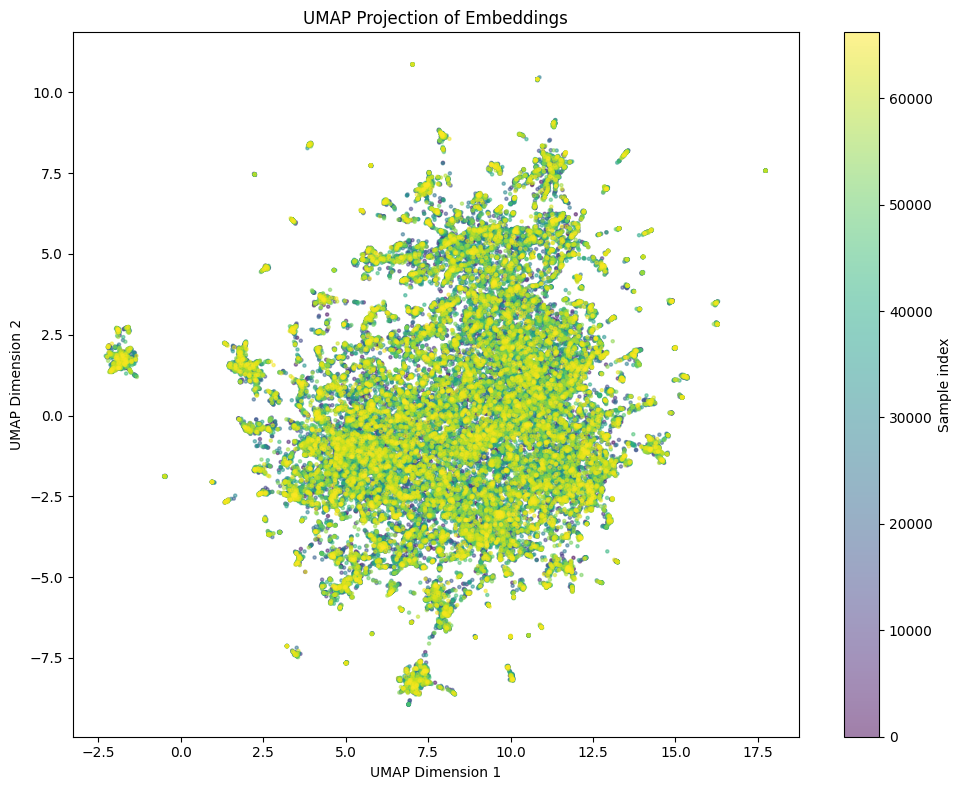

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import umap
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
final_embeddings_umap = umap_reducer.fit_transform(embeddings)
# Plot the 2D UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(final_embeddings_umap[:, 0], final_embeddings_umap[:, 1], 
            s=5,  # Point size
            alpha=0.5,  # Transparency
            c=np.arange(len(final_embeddings_umap)),  # Color points by index
            cmap='viridis')  # Color map

plt.colorbar(label='Sample index')
plt.title('UMAP Projection of Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()

In [7]:
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Set the output directory for Kaggle
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if GPU is available
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

# Use cuML's UMAP implementation for GPU acceleration
try:
    import cuml
    from cuml.manifold import UMAP
    print("Using cuML UMAP implementation (GPU accelerated)")
    use_gpu = True
except ImportError:
    import umap
    print("Using standard UMAP implementation (CPU only)")
    use_gpu = False

# Define expanded parameter combinations
n_components_range = range(10, 101, 10)  # 10, 20, 30, ..., 100
n_neighbors_range = range(10, 101, 10)   # 10, 20, 30, ..., 100
min_dist_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 0.99]
distance_thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

# Path to files
progress_file = os.path.join(OUTPUT_DIR, "clustering_progress.json")
results_file = os.path.join(OUTPUT_DIR, "clustering_results.csv")

# Generate all parameter combinations
umap_params = []
for n_comp in n_components_range:
    for n_neigh in n_neighbors_range:
        for min_dist in min_dist_values:
            umap_params.append((n_comp, n_neigh, min_dist))

# Load existing results and progress if available
results = []
completed_params = set()

if os.path.exists(results_file):
    df_results = pd.read_csv(results_file)
    results = df_results.to_dict('records')
    
    # Extract already completed parameter combinations
    for row in results:
        param_key = (row["n_components"], row["n_neighbors"], row["min_dist"], row["distance_threshold"])
        completed_params.add(param_key)
    
    print(f"Loaded {len(results)} existing results from {results_file}")

if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        progress_data = json.load(f)
        last_index = progress_data.get('last_index', 0)
        print(f"Resuming from parameter combination index {last_index}")
else:
    last_index = 0

# Convert embeddings to the appropriate format for GPU (if using GPU)
if use_gpu:
    # Convert numpy array to cuDF DataFrame or cuML array
    embeddings_gpu = cuml.array.Array(embeddings)
else:
    embeddings_gpu = embeddings

# Process remaining parameter combinations
try:
    for param_idx, (n_comp, n_neigh, min_dist) in enumerate(umap_params[last_index:], start=last_index):
        print(f"Processing UMAP: n_components={n_comp}, n_neighbors={n_neigh}, min_dist={min_dist} [{param_idx+1}/{len(umap_params)}]")
        
        # Apply UMAP with GPU acceleration if available
        if use_gpu:
            umap_reducer = UMAP(
                n_components=n_comp, 
                n_neighbors=n_neigh, 
                min_dist=min_dist, 
                metric='cosine', 
                random_state=42
            )
            umap_embeddings = umap_reducer.fit_transform(embeddings_gpu)
            # Convert back to numpy for scikit-learn compatibility
            umap_embeddings = umap_embeddings.get() if hasattr(umap_embeddings, 'get') else umap_embeddings.to_numpy()
        else:
            umap_reducer = umap.UMAP(
                n_components=n_comp, 
                n_neighbors=n_neigh, 
                min_dist=min_dist, 
                metric='cosine', 
                random_state=42
            )
            umap_embeddings = umap_reducer.fit_transform(embeddings_gpu)
        
        for dist_thresh in distance_thresholds:
            # Skip if this combination has already been processed
            param_key = (n_comp, n_neigh, min_dist, dist_thresh)
            if param_key in completed_params:
                print(f"  - Skipping AgglomerativeClustering with distance_threshold={dist_thresh} (already processed)")
                continue
                
            print(f"  - Applying AgglomerativeClustering with distance_threshold={dist_thresh}")
            
            # Apply Agglomerative Clustering
            cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=dist_thresh)
            labels = cluster_model.fit_predict(umap_embeddings)
            num_clusters = len(set(labels))
            
            # Compute silhouette score only if there is more than 1 cluster and more than 1 sample
            if num_clusters > 1 and len(set(labels)) < len(labels):
                try:
                    sil_score = silhouette_score(umap_embeddings, labels)
                except:
                    sil_score = -1  # Error in calculation
            else:
                sil_score = -1  # Invalid case (all points in one cluster)
            
            # Save cluster assignments to JSON
            clustered_keywords = {}
            for keyword, cluster in zip(keywords_2011, labels):
                clustered_keywords.setdefault(str(cluster), []).append(keyword)
            
            filename = os.path.join(OUTPUT_DIR, f"clustered_keywords_ncomp{n_comp}_nneigh{n_neigh}_mindist{min_dist}_dthresh{dist_thresh}.json")
            with open(filename, "w", encoding="utf-8") as f:
                json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)
            print(f"    - Saved results to {filename}")
            
            # Store results in table
            results.append({
                "n_components": n_comp,
                "n_neighbors": n_neigh,
                "min_dist": min_dist,
                "distance_threshold": dist_thresh,
                "num_clusters": num_clusters,
                "silhouette_score": sil_score
            })
            
            # Save results incrementally
            df_results = pd.DataFrame(results)
            df_results.to_csv(results_file, index=False)
            
            # Update progress
            with open(progress_file, 'w') as f:
                json.dump({'last_index': param_idx}, f)
            
            completed_params.add(param_key)
        
        # Free memory manually - important for GPU
        if use_gpu:
            del umap_reducer
            import gc
            gc.collect()
            torch.cuda.empty_cache()
        
except KeyboardInterrupt:
    print("\nProcess interrupted by user. Progress has been saved.")

print(f"\nClustering completed/paused. Results saved in '{results_file}'.")

# If we have enough results, generate the visualizations
if results:
    df_results = pd.DataFrame(results)
    
    # Find best parameters
    valid_results = df_results[df_results["silhouette_score"] > 0]
    if not valid_results.empty:
        best_params = valid_results.loc[valid_results["silhouette_score"].idxmax()]
        print(f"\nBest parameters found so far:")
        print(f"  n_components: {best_params['n_components']}")
        print(f"  n_neighbors: {best_params['n_neighbors']}")
        print(f"  min_dist: {best_params['min_dist']}")
        print(f"  distance_threshold: {best_params['distance_threshold']}")
        print(f"  num_clusters: {best_params['num_clusters']}")
        print(f"  silhouette_score: {best_params['silhouette_score']}")
    
    # Create a more readable visualization with subplots
    plt.figure(figsize=(20, 15))
    
    # Group by n_components and create a subplot for each
    unique_n_comp = sorted(df_results["n_components"].unique())
    num_plots = len(unique_n_comp)
    rows = int(np.ceil(num_plots / 3))  # 3 plots per row
    
    for i, n_comp in enumerate(unique_n_comp):
        ax = plt.subplot(rows, 3, i+1)
        
        comp_data = df_results[df_results["n_components"] == n_comp]
        for (n_neigh, min_dist), group in comp_data.groupby(["n_neighbors", "min_dist"]):
            valid_data = group[group["silhouette_score"] > -1]
            if not valid_data.empty:
                ax.plot(
                    valid_data["distance_threshold"], 
                    valid_data["silhouette_score"], 
                    marker="o", 
                    label=f"n_neigh={n_neigh}, min_dist={min_dist}"
                )
        
        ax.set_xlabel("Distance Threshold")
        ax.set_ylabel("Silhouette Score")
        ax.set_title(f"n_components = {n_comp}")
        ax.grid(True)
        
        # Only show legend for the first subplot to save space
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "silhouette_scores.png"), dpi=300, bbox_inches="tight")
    
    try:
        # Create a heatmap for top parameter combinations
        top_results = df_results.sort_values("silhouette_score", ascending=False).head(100)
        
        plt.figure(figsize=(12, 8))
        pivot = pd.pivot_table(
            top_results, 
            values="silhouette_score", 
            index=["n_components", "n_neighbors"],
            columns=["min_dist", "distance_threshold"]
        )
        plt.imshow(pivot, cmap="viridis")
        plt.colorbar(label="Silhouette Score")
        plt.title("Top 100 Parameter Combinations by Silhouette Score")
        plt.savefig(os.path.join(OUTPUT_DIR, "top_parameters_heatmap.png"), dpi=300)
    except:
        print("Could not create heatmap visualization (likely due to sparse data)")

GPU available: True
GPU device: Tesla P100-PCIE-16GB


UnsupportedCUDAError: A GPU with NVIDIA Volta™ (Compute Capability 7.0) or newer architecture is required.
Detected GPU 0: Tesla P100-PCIE-16GB                                                                                                                                                                                                                                            
Detected Compute Capability: 6.0

In [6]:
!zip -r output_files.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/clustered_keywords_ncomp20_nneigh25_mindist0.025_dthresh1.5.json (deflated 79%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh20_mindist0.05_dthresh2.5.json (deflated 79%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh30_mindist0.5_dthresh1.0.json (deflated 77%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh25_mindist0.1_dthresh1.5.json (deflated 78%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh20_mindist0.025_dthresh0.5.json (deflated 78%)
  adding: kaggle/working/clustered_keywords_ncomp20_nneigh20_mindist0.025_dthresh2.0.json (deflated 79%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh25_mindist0.025_dthresh0.5.json (deflated 78%)
  adding: kaggle/working/clustered_keywords_ncomp20_nneigh30_mindist0.1_dthresh2.5.json (deflated 79%)
  adding: kaggle/working/clustered_keywords_ncomp30_nneigh20_mindist0.1_dthresh2.5.json (deflated 79%)
  adding: kaggle/working/c

In [5]:
import umap

umap_reducer = umap.UMAP(n_components=20, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42)
final_embeddings_umap = umap_reducer.fit_transform(embeddings)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
final_embeddings_umap.shape

(21246, 20)

In [25]:
from sklearn.cluster import AgglomerativeClustering

# Apply UMAP first
umap_embeddings = umap.UMAP(n_components=20, n_neighbors=25, min_dist=0.025, metric='cosine', random_state=42).fit_transform(embeddings)

# Apply Hierarchical Clustering
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)  # Auto-detect clusters
labels = cluster_model.fit_predict(umap_embeddings)

print("Number of Clusters:", len(set(labels)) - (1 if -1 in labels else 0))


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Number of Clusters: 679


In [28]:
max(labels)

678

In [27]:
import json

# Assume `keywords` is a list where each index corresponds to an embedding
clustered_keywords = {}
for keyword, cluster in zip(keywords_2011, labels):
    clustered_keywords.setdefault(str(cluster), []).append(keyword)

# Save as JSON
with open("clustered_keywords.json", "w", encoding="utf-8") as f:
    json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)

print("Clustered keywords saved to clustered_keywords.json")


Clustered keywords saved to clustered_keywords.json


In [30]:
import json
import umap
from sklearn.cluster import AgglomerativeClustering

# Define parameter combinations
umap_params = [
    (20, 25, 0.1), (20, 25, 0.5), (20, 25, 0.05), (20, 25, 0.025),
    (20, 30, 0.5), (20, 30, 0.1), (20, 30, 0.05), (20, 30, 0.025),
    (20, 20, 0.025), (20, 20, 0.05), (20, 20, 0.1), (20, 20, 0.5),
    (30, 25, 0.05), (30, 25, 0.025), (30, 25, 0.1), (30, 25, 0.5),
    (30, 30, 0.5), (30, 30, 0.1), (30, 30, 0.05), (30, 30, 0.025),
    (30, 20, 0.025), (30, 20, 0.05), (30, 20, 0.1), (30, 20, 0.5)
]

# Loop through each parameter combination
for n_comp, n_neigh, min_dist in umap_params:
    print(f"Processing UMAP with n_components={n_comp}, n_neighbors={n_neigh}, min_dist={min_dist}")

    # Apply UMAP
    umap_reducer = umap.UMAP(n_components=n_comp, n_neighbors=n_neigh, min_dist=min_dist, metric='cosine', random_state=42)
    umap_embeddings = umap_reducer.fit_transform(embeddings)

    # Apply Hierarchical Clustering
    cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
    labels = cluster_model.fit_predict(umap_embeddings)

    # Organize results
    clustered_keywords = {}
    for keyword, cluster in zip(keywords_2011, labels):
        clustered_keywords.setdefault(str(cluster), []).append(keyword)

    # Define filename
    filename = f"clustered_keywords_ncomp{n_comp}_nneigh{n_neigh}_mindist{min_dist}.json"

    # Save to JSON file
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)

    print(f"Saved results to {filename}")


Processing UMAP with n_components=20, n_neighbors=25, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh25_mindist0.1.json
Processing UMAP with n_components=20, n_neighbors=25, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh25_mindist0.5.json
Processing UMAP with n_components=20, n_neighbors=30, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh30_mindist0.5.json
Processing UMAP with n_components=20, n_neighbors=30, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh30_mindist0.1.json
Processing UMAP with n_components=20, n_neighbors=30, min_dist=0.05


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh30_mindist0.05.json
Processing UMAP with n_components=20, n_neighbors=30, min_dist=0.025


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh30_mindist0.025.json
Processing UMAP with n_components=20, n_neighbors=20, min_dist=0.025


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh20_mindist0.025.json
Processing UMAP with n_components=20, n_neighbors=20, min_dist=0.05


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh20_mindist0.05.json
Processing UMAP with n_components=20, n_neighbors=20, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh20_mindist0.1.json
Processing UMAP with n_components=20, n_neighbors=20, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp20_nneigh20_mindist0.5.json
Processing UMAP with n_components=30, n_neighbors=25, min_dist=0.05


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh25_mindist0.05.json
Processing UMAP with n_components=30, n_neighbors=25, min_dist=0.025


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh25_mindist0.025.json
Processing UMAP with n_components=30, n_neighbors=25, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh25_mindist0.1.json
Processing UMAP with n_components=30, n_neighbors=25, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh25_mindist0.5.json
Processing UMAP with n_components=30, n_neighbors=30, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh30_mindist0.5.json
Processing UMAP with n_components=30, n_neighbors=30, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh30_mindist0.1.json
Processing UMAP with n_components=30, n_neighbors=30, min_dist=0.05


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh30_mindist0.05.json
Processing UMAP with n_components=30, n_neighbors=30, min_dist=0.025


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh30_mindist0.025.json
Processing UMAP with n_components=30, n_neighbors=20, min_dist=0.025


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh20_mindist0.025.json
Processing UMAP with n_components=30, n_neighbors=20, min_dist=0.05


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh20_mindist0.05.json
Processing UMAP with n_components=30, n_neighbors=20, min_dist=0.1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh20_mindist0.1.json
Processing UMAP with n_components=30, n_neighbors=20, min_dist=0.5


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved results to clustered_keywords_ncomp30_nneigh20_mindist0.5.json


In [9]:
import umap
from sklearn.cluster import AgglomerativeClustering

# Load JSON and extract unique keywords for a given year
def load_keywords_from_json(file_path, target_year):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    keywords = []
    for entry in data:
        if entry['year'] == target_year:
            keywords.extend(entry['keywords'])
    
    return list(set(keywords))  # Remove duplicates

# Load Sentence-BERT model (optimized for GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# File path to dataset
file_path = "/kaggle/input/2011-2018-mrs-dataset/2011-2018-spring.json"

years = list(range(2011, 2019))  # 2011 to 2018

for year in years:
    print(f"Processing year {year}...")
    
    # Load keywords for the specific year
    keywords = load_keywords_from_json(file_path, target_year=year)
    
    if not keywords:
        print(f"No keywords found for {year}, skipping.")
        continue
    
    # Encode keywords using Sentence-BERT
    dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
    embeddings = []
    
    for batch in dataloader:
        batch_embeddings = model.encode(batch, show_progress_bar=True)
        embeddings.append(batch_embeddings)
    
    embeddings = np.vstack(embeddings)
    
    # Apply UMAP dimensionality reduction
    umap_embeddings = umap.UMAP(n_components=30, n_neighbors=20, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embeddings)
    
    # Apply Hierarchical Clustering
    cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
    labels = cluster_model.fit_predict(umap_embeddings)
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Year {year}: Number of Clusters = {num_clusters}")
    
    # Organize clustered keywords into a dictionary
    clustered_keywords = {}
    for keyword, cluster in zip(keywords, labels):
        clustered_keywords.setdefault(str(cluster), []).append(keyword)
    
    # Save the clusters to a JSON file
    output_filename = f"clustered_keywords_spring_{year}.json"
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)
    
    print(f"Clustered keywords saved to {output_filename}\n")

print("Processing completed for all years!")


Processing year 2011...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2011: Number of Clusters = 482
Clustered keywords saved to clustered_keywords_spring_2011.json

Processing year 2012...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2012: Number of Clusters = 585
Clustered keywords saved to clustered_keywords_spring_2012.json

Processing year 2013...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2013: Number of Clusters = 826
Clustered keywords saved to clustered_keywords_spring_2013.json

Processing year 2014...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2014: Number of Clusters = 798
Clustered keywords saved to clustered_keywords_spring_2014.json

Processing year 2015...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2015: Number of Clusters = 752
Clustered keywords saved to clustered_keywords_spring_2015.json

Processing year 2016...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2016: Number of Clusters = 739
Clustered keywords saved to clustered_keywords_spring_2016.json

Processing year 2017...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2017: Number of Clusters = 722
Clustered keywords saved to clustered_keywords_spring_2017.json

Processing year 2018...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Year 2018: Number of Clusters = 732
Clustered keywords saved to clustered_keywords_spring_2018.json

Processing completed for all years!


In [19]:
import os

def load_keywords_from_txt(file_path):
    keywords = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("Keywords: "):
                keyword_list = line.replace("Keywords: ", "").strip()
                keywords.extend([kw.strip() for kw in keyword_list.split(",")])
    return list(set(keywords))  # Remove duplicates

# Folder containing JSON files
input_folder = "/kaggle/input/keywordscraped/"
output_folder = "./results/"

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace(".txt", ".json"))

        # Load keywords
        keywords = load_keywords_from_txt(file_path)
        print(len(keywords))
        print
        if not keywords:
            print(f"Skipping {filename}: No keywords found.")
            continue

        # Encode keywords using Sentence-BERT
        dataloader = DataLoader(keywords, batch_size=1024, shuffle=False)
        embeddings = []
        for batch in dataloader:
            batch_embeddings = model.encode(batch, show_progress_bar=True)
            embeddings.append(batch_embeddings)
        embeddings = np.vstack(embeddings)

        # Apply UMAP
        umap_embeddings = umap.UMAP(n_components=20, n_neighbors=25, min_dist=0.025, metric='cosine', random_state=42).fit_transform(embeddings)

        # Apply Hierarchical Clustering
        cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
        labels = cluster_model.fit_predict(umap_embeddings)

        print(f"{filename}: Number of Clusters - {len(set(labels))}")

        # Save clustered keywords as JSON
        clustered_keywords = {}
        for keyword, cluster in zip(keywords, labels):
            clustered_keywords.setdefault(str(cluster), []).append(keyword)

        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)

        print(f"Clustered keywords saved to {output_path}")

317
['additives', 'intercalated', 'organometallic', 'combinatorial', 'metrics']


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2019-fall-keywords.txt: Number of Clusters - 35
Clustered keywords saved to ./results/2019-fall-keywords.json
289
['additives', 'sol-gel', 'Na', 'microscale', 'molecular weight']


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2019-spring-keywords.txt: Number of Clusters - 37
Clustered keywords saved to ./results/2019-spring-keywords.json
317
['additives', 'ion-beam assisted deposition', 'intercalated', 'qubit', 'organometallic']


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2022-spring-keywords.txt: Number of Clusters - 44
Clustered keywords saved to ./results/2022-spring-keywords.json


In [20]:
!zip -r output_files.zip /kaggle/working/results

updating: kaggle/working/results/ (stored 0%)
updating: kaggle/working/results/2019-fall-keywords.json (deflated 73%)
updating: kaggle/working/results/2022-spring-keywords.json (deflated 73%)
updating: kaggle/working/results/2019-spring-keywords.json (deflated 73%)


In [34]:
import json
import os
import pandas as pd

# Define the path to the ZIP file
extract_folder = "/kaggle/input/clusters/Clusters_2011_Fall"  # Change this if needed

# Initialize list to store results
results = []

# Process each JSON file
for filename in os.listdir(extract_folder):
    if filename.endswith(".json"):
        file_path = os.path.join(extract_folder, filename)
        
        # Extract UMAP parameters from filename
        parts = filename.replace("clustered_keywords_", "").replace(".json", "").split("_")
        n_comp = parts[0].replace("ncomp", "")
        n_neigh = parts[1].replace("nneigh", "")
        min_dist = parts[2].replace("mindist", "")
        
        # Load JSON file
        with open(file_path, "r", encoding="utf-8") as f:
            clustered_keywords = json.load(f)
        
        # Count number of clusters
        num_clusters = len(clustered_keywords)

        # Store results
        results.append({
            "n_components": int(n_comp),
            "n_neighbors": int(n_neigh),
            "min_dist": min_dist,
            "num_clusters": num_clusters
        })

# Convert to Pandas DataFrame
df = pd.DataFrame(results)

# Sort for better readability
df = df.sort_values(by=["n_components", "n_neighbors", "min_dist"])

# Display the table
print(df)

# Save to CSV (optional)
df.to_csv("umap_clustering_results.csv", index=False)
print("Results saved to umap_clustering_results.csv")


    n_components  n_neighbors min_dist  num_clusters
8             20           20    0.025           690
13            20           20     0.05           737
9             20           20      0.1           829
11            20           20      0.5          1859
21            20           25  0.0.025           679
2             20           25     0.05           713
19            20           25      0.1           825
12            20           25      0.5          1851
10            20           30    0.025           659
3             20           30     0.05           700
22            20           30      0.1           798
6             20           30      0.5          1809
17            30           20    0.025           683
4             30           20     0.05           735
15            30           20      0.1           833
7             30           20      0.5          1869
20            30           25    0.025           675
23            30           25     0.05        

In [35]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Fit PCA on embeddings


# Load JSON and extract keywords for a given year
def load_keywords_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    keywords = []
    for entry in data:
        keywords.extend(entry['keywords'])
    return list(set(keywords)) 



keywords_2011 = load_keywords_from_json('/kaggle/input/keywords/keywords-fall-2021.json')
dataloader = DataLoader(keywords_2011, batch_size=1024, shuffle=False)
embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.append(batch_embeddings)
    
embeddings = np.vstack(embeddings)
pca = PCA()
pca.fit(embeddings)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings)
# Apply Hierarchical Clustering
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
labels = cluster_model.fit_predict(reduced_embeddings)

print(f"{filename}: Number of Clusters - {len(set(labels))}")

# Save clustered keywords as JSON
clustered_keywords = {}
for keyword, cluster in zip(keywords, labels):
    clustered_keywords.setdefault(str(cluster), []).append(keyword)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(clustered_keywords, f, indent=4, ensure_ascii=False)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

2022-spring-keywords.txt: Number of Clusters - 1678


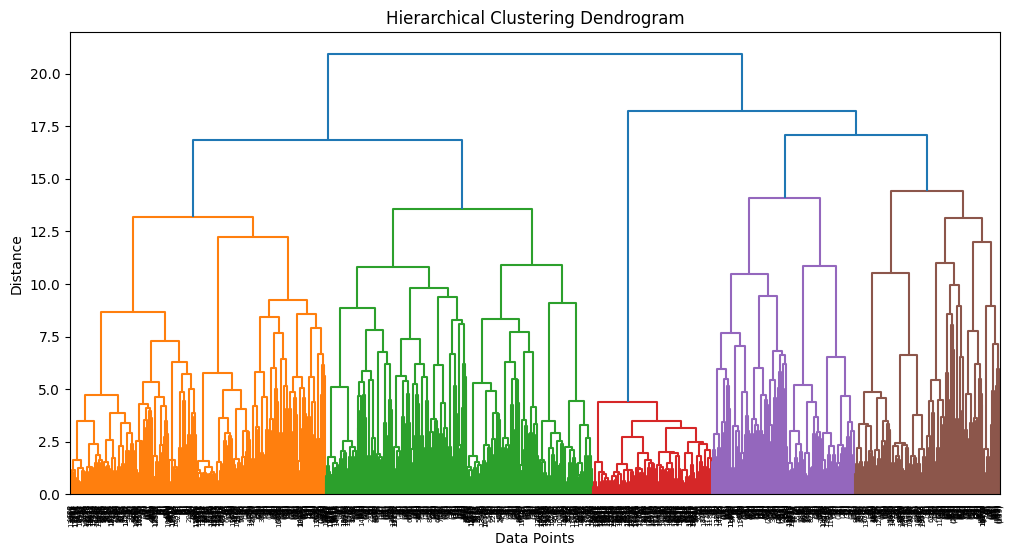

In [36]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Compute the linkage matrix
linkage_matrix = sch.linkage(reduced_embeddings, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, truncate_mode="level", p=10)  # Show only first 10 levels
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


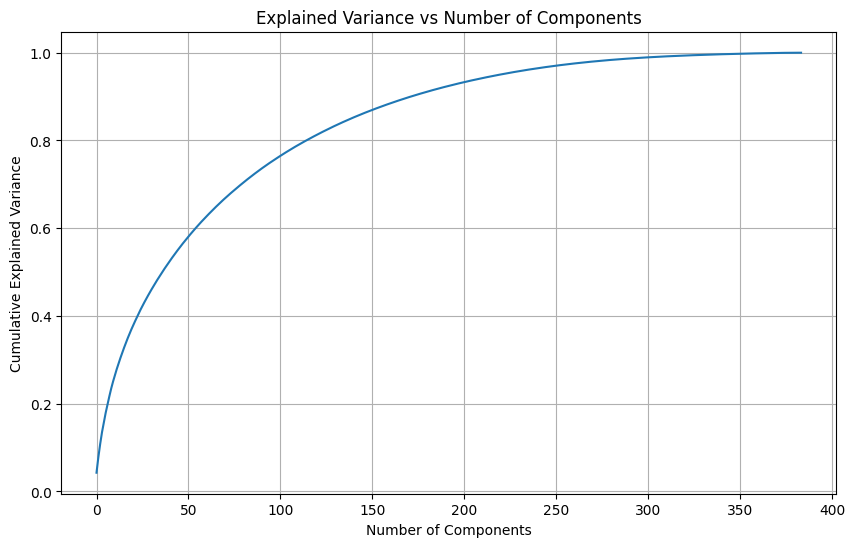

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Fit PCA on embeddings
pca = PCA()
pca.fit(embeddings)

# Plot the explained variance to find the optimal number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()


In [34]:
print(np.where((np.cumsum(pca.explained_variance_ratio_))==0.95066535))

(array([], dtype=int64),)


In [7]:
optimal_components = 220
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings)

print(reduced_embeddings.shape) 

(21246, 200)


In [10]:
# !pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00


In [28]:
!pip install hdbscan
!pip install trimap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.5 MB/s eta 0:00:00ta 0:00:01


In [37]:
from umap import UMAP
umap_model = UMAP(n_neighbors=5, min_dist=0.1, n_components=50, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)
umap_embeddings.shape

(21246, 50)

In [31]:
sentences = [
    "oxide nanowire formation",
    "Fe3O4 nanoparticles",
    "Nanostructure electrodes",
    "Vanadium dioxide nanowires",
    "single-gap nanowire devices",
    "Ga2O3 Nanowires",
    "Cuprous oxide semiconductors",
    "III-nitride nanowires",
    "n-type Metal Oxide Nanowires",
    "ZnO Nanowires",
    "Nanowires nanofoams",
    "Nanowire Transistors",
    "Nanostructured oxide composites",
    "CdS nanowires",
    "Zincblende GaAs Nanowires",
    "metal oxide nanowires",
    "Oxide layer growth",
    "Nanowire-based solar cells",
    "ZnO nanorod arrays",
    "nanoparticle doping",
    "Polymer Nanowire Arrays",
    "Nanostructured Transparent Conductive Oxides",
    "Si nanowire anodes",
    "Core-Shell Nanowires"  
]

# 2. Calculate embeddings by calling model.encode()
embeddings_new = model.encode(sentences)
print(embeddings_new.shape)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(24, 384)


In [49]:
similarities=model.similarity(embeddings_new,embeddings_new)
print(similarities)

tensor([[1.0000, 0.5149, 0.5282, 0.6412, 0.5836, 0.6757, 0.5012, 0.5498, 0.7974,
         0.6948, 0.7231, 0.6347, 0.5350, 0.5136, 0.5534, 0.8770, 0.5691, 0.5842,
         0.5012, 0.5309, 0.5423, 0.5320, 0.5491, 0.6147],
        [0.5149, 1.0000, 0.4158, 0.3359, 0.3040, 0.4911, 0.3688, 0.3587, 0.4469,
         0.4095, 0.5068, 0.3339, 0.4934, 0.2764, 0.2979, 0.5247, 0.3051, 0.2833,
         0.3903, 0.5575, 0.3258, 0.4515, 0.3173, 0.3971],
        [0.5282, 0.4158, 1.0000, 0.5167, 0.5114, 0.5118, 0.4310, 0.5325, 0.5893,
         0.5619, 0.6284, 0.5479, 0.4515, 0.4708, 0.5445, 0.6422, 0.2723, 0.5440,
         0.4630, 0.5408, 0.5137, 0.5330, 0.5266, 0.5352],
        [0.6412, 0.3359, 0.5167, 1.0000, 0.5313, 0.5548, 0.3552, 0.5181, 0.6253,
         0.6046, 0.6126, 0.5110, 0.3353, 0.5035, 0.4985, 0.6778, 0.2998, 0.5950,
         0.4009, 0.4365, 0.5161, 0.4306, 0.4469, 0.5467],
        [0.5836, 0.3040, 0.5114, 0.5313, 1.0000, 0.5881, 0.3599, 0.6009, 0.6545,
         0.6627, 0.7171, 0.7114, 0.2074

In [50]:
optimal_components = 200
pca = PCA(n_components=optimal_components)
reduced_embeddings_new = pca.fit_transform(embeddings_new)

print(reduced_embeddings_new.shape)

ValueError: n_components=200 must be between 0 and min(n_samples, n_features)=24 with svd_solver='full'

In [55]:
umap_model = UMAP(n_neighbors=2, min_dist=0.1, n_components=200, metric='cosine')
umap_embeddings_new = umap_model.fit_transform(embeddings_new)
umap_embeddings_new.shape

(24, 200)

In [56]:
similarity=model.similarity(umap_embeddings_new,umap_embeddings_new)
print(similarity)

tensor([[1.0000, 0.9502, 0.9984, 0.9854, 0.9004, 0.9132, 0.8720, 0.9175, 0.9778,
         0.9151, 0.9506, 0.9454, 0.8861, 0.9423, 0.9158, 1.0000, 0.9620, 0.9375,
         0.9015, 0.9504, 0.9142, 0.8917, 0.9450, 0.9212],
        [0.9502, 1.0000, 0.9433, 0.9438, 0.9502, 0.9236, 0.8956, 0.9064, 0.9492,
         0.9255, 0.9999, 0.9969, 0.9035, 0.9771, 0.9261, 0.9497, 0.9285, 0.9740,
         0.9041, 1.0000, 0.9587, 0.9124, 0.9966, 0.9639],
        [0.9984, 0.9433, 1.0000, 0.9793, 0.8941, 0.9046, 0.8650, 0.9098, 0.9715,
         0.9065, 0.9438, 0.9381, 0.8785, 0.9363, 0.9072, 0.9987, 0.9499, 0.9326,
         0.8945, 0.9435, 0.9080, 0.8841, 0.9377, 0.9139],
        [0.9854, 0.9438, 0.9793, 1.0000, 0.8939, 0.9084, 0.8745, 0.8949, 0.9609,
         0.9104, 0.9440, 0.9382, 0.8806, 0.9365, 0.9111, 0.9852, 0.9400, 0.9311,
         0.8989, 0.9439, 0.9093, 0.8871, 0.9378, 0.9133],
        [0.9004, 0.9502, 0.8941, 0.8939, 1.0000, 0.8911, 0.8649, 0.8782, 0.9130,
         0.8925, 0.9489, 0.9397, 0.8629

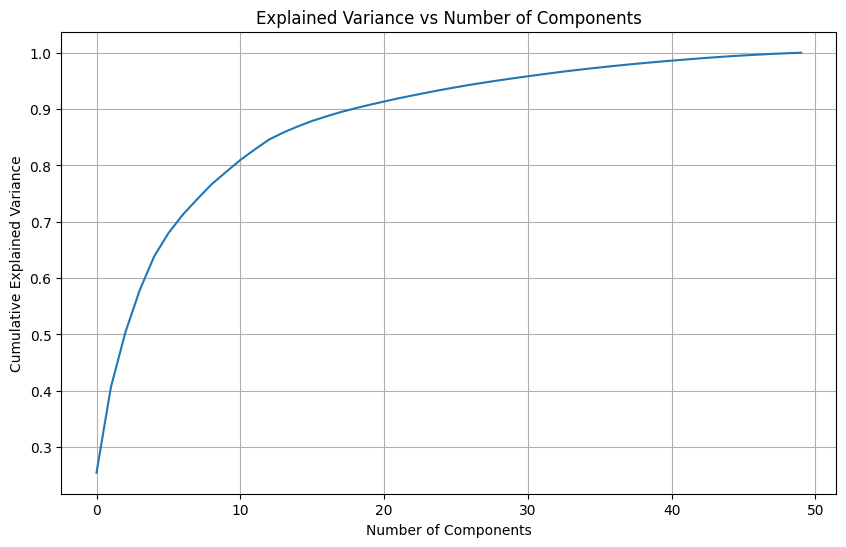

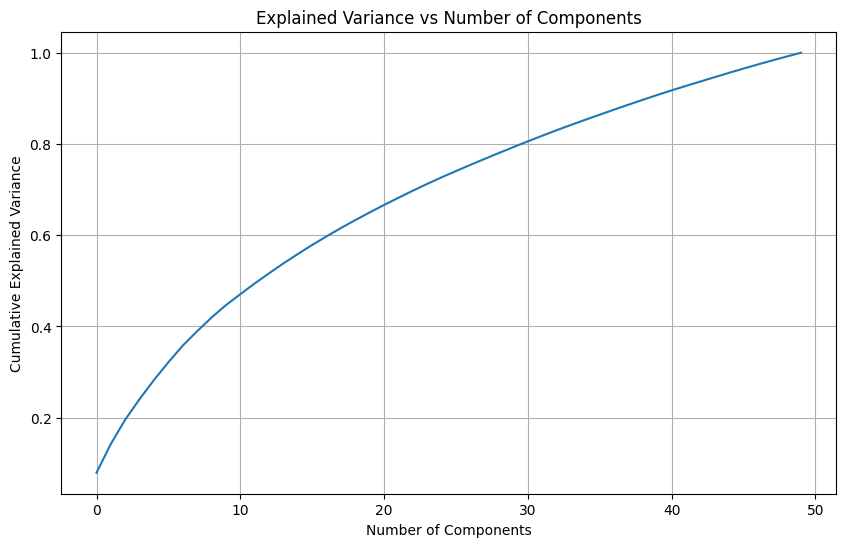

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Fit PCA on embeddings
pca = PCA()
pca.fit(umap_embeddings)

# Plot the explained variance to find the optimal number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()


pca.fit(reduced_embeddings_new)

# Plot the explained variance to find the optimal number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

In [21]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def knn_consistency(emb1, emb2, k=5):
    nn1 = NearestNeighbors(n_neighbors=k).fit(emb1)
    nn2 = NearestNeighbors(n_neighbors=k).fit(emb2)
    neighbors1 = nn1.kneighbors(emb1, return_distance=False)
    neighbors2 = nn2.kneighbors(emb2, return_distance=False)
    
    overlap = np.mean([len(set(neighbors1[i]) & set(neighbors2[i])) / k for i in range(emb1.shape[0])])
    return overlap

overlap_score = knn_consistency(embeddings, umap_embeddings, k=10)
print(f"KNN Consistency: {overlap_score:.4f}")


KNN Consistency: 0.5187


(21246, 50)

In [ ]:
# Load similarity matrix and keywords
threshold = 0.5
output_file = 'keyword_clusters.json'

# Step 1: Load existing data if file exists
try:
    with open(output_file, 'r') as f:
        output_data = json.load(f)
except FileNotFoundError:
    output_data = {}

if "2011_Fall" not in output_data:
    output_data["2011_Fall"] = []

clusters = output_data["2011_Fall"]
visited = set()

# Step 2: Find clusters based on max similarity per column
num_keywords = len(keywords_2011)

for i in range(num_keywords):
    if i in visited:
        continue

    similar_keywords = []
    for j in range(num_keywords):
        if similarities[i][j] >= threshold:
            # Check if 'i' is the most similar keyword for 'j'
            max_sim_idx = np.argmax(similarities[:, j])
            if max_sim_idx == i:
                similar_keywords.append(keywords_2011[j])
                visited.add(j)

    if similar_keywords:
        clusters.append(similar_keywords)

# Step 3: Save clusters to JSON
output_data["2011_Fall"] = clusters
with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=4)

print(f"Clusters saved! Found {len(clusters)} clusters.")

In [7]:
import networkx as nx
import numpy as np
import json
import community  # Install with `pip install python-louvain`

# Load similarity matrix
threshold = 0.5
G = nx.Graph()
num_keywords = len(keywords)

# Step 1: Build Graph
for i in range(num_keywords):
    for j in range(i + 1, num_keywords):
        if similarities[i][j] >= threshold:
            G.add_edge(keywords[i], keywords[j], weight=similarities[i][j])

# Step 2: Apply Louvain Clustering
partition = community.best_partition(G, weight='weight')

# Step 3: Convert to Cluster List
clusters = {}
for keyword, cluster_id in partition.items():
    clusters.setdefault(cluster_id, []).append(keyword)

clusters = list(clusters.values())  # Convert dict to list

# Step 4: Save results
output_file = 'keyword_clusters.json'
with open(output_file, 'w') as f:
    json.dump({"2011_Fall": clusters}, f, indent=4)


print(f"Clusters saved! Found {len(clusters)} clusters.")

KeyboardInterrupt: 

In [7]:
# !pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp310-cp310-linux_x86_64.whl size=2364598 sha256=a13bd0fc4980c01bc295bc9862435acd15aec4b463e8902d02a81f3e933724f4
  Stored in directory: /root/.cache/pip/wheels/af/a9/3e/3e5d59ee41664eb31a4e6de67d1846f86d16d93c45f277c4e7
Successfully built hnswlib


In [8]:
# pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.3 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load existing data if file exists
output_file = 'keyword_clusters.json'
threshold = 0.5
visited = set()
try:
    with open(output_file, 'r') as f:
        output_data = json.load(f)
except FileNotFoundError:
    output_data = {}

if "2011_Fall" not in output_data:
    output_data["2011_Fall"] = []

clusters = output_data["2011_Fall"]

for i in range(len(similarities)):
    if i in visited:
        continue
    similar_keywords = [keywords_2011[j] for j in range(len(similarities)) if similarities[i][j] >= threshold]
    for kw in similar_keywords:
        visited.add(keywords_2011.index(kw))
    if similar_keywords not in clusters:
        clusters.append(similar_keywords)
        with open(output_file, 'w') as f:
            json.dump(output_data, f, indent=4)

print("Clusters appended and saved to 'keyword_clusters_2011.json'")

In [ ]:
# Load the keywords
keywords_2011_spring = load_keywords_from_json('/kaggle/input/2011-2018-mrs-dataset/2011-2018-spring.json')

# Encode keywords in batches
dataloader = DataLoader(keywords_2011_spring, batch_size=1024, shuffle=False)
embeddings = []
for batch in dataloader:
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.append(batch_embeddings)
embeddings = np.vstack(embeddings)


similarities = model.similarity(embeddings, embeddings)


In [ ]:
# Load existing data if file exists
output_file = 'keyword_clusters.json'
threshold = 0.5
visited = set()
try:
    with open(output_file, 'r') as f:
        output_data = json.load(f)
except FileNotFoundError:
    output_data = {}

if "2011_Spring" not in output_data:
    output_data["2011_Spring"] = []

clusters = output_data["2011_Spring"]


for i in range(len(similarities)):
    if i in visited:
        continue
    similar_keywords = [keywords_2011_spring[j] for j in range(len(similarities)) if similarities[i][j] >= threshold]
    for kw in similar_keywords:
        visited.add(keywords_2011_spring.index(kw))
    if similar_keywords not in clusters:
        clusters.append(similar_keywords)
        with open(output_file, 'w') as f:
            json.dump(output_data, f, indent=4)

print("Clusters appended and saved to 'keyword_clusters.json'")

In [ ]:
# rm -rf /kaggle/working/*

In [ ]:
!pip install cdlib

In [ ]:
from cdlib import algorithms  # Community detection library

G = nx.Graph()
for i in range(len(similarities)):
    for j in range(len(similarities)):
        if i != j:
            G.add_edge(i, j, weight=similarities[i][j])

# Apply Louvain community detection
communities = algorithms.louvain(G, weight='weight')

# Convert to clusters
clusters = []
for com in communities.communities:
    cluster = [keywords_2011_spring[i] for i in com]
    clusters.append(cluster)

# Save clusters
with open('output/clusters_2011_spring.json', 'w') as f:
    json.dump({'2011_Spring': clusters}, f, indent=4)

print("Clusters saved!")

In [3]:
import os
import zipfile

def zip_output_directory(output_dir, zip_name):
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

zip_output_directory('/kaggle/working/', 'output_files.zip')
print("All files in the output directory have been zipped into 'output_files.zip'.")


OSError: [Errno 28] No space left on device